# Cross-lingual Similarity of Multilingual Representations Revisited

This notebook walks you through the main results from our paper.

To fully reproduce the work, one should representations from XLM-R Normformers and  Meta's XLM-R and XGLM models extracted.

To extract them follow the instruction in the README.md. 

For now, we suggest to check the results below. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(font_scale=2) 
plt.style.use('seaborn-whitegrid')

In [4]:
def load_dfs(model_classes, tasks):
    dfs = {}

    for model_class in model_classes:
        task_dfs = []
        for task in tasks:
            scores_dfs = pickle.load(open(f"../experiments/encoded_datasets/xnli/{model_class}-{task}-all_models.pkl", 'rb'))
            scores_dfs = {k: pd.DataFrame(dict(v)).melt(var_name="pair", value_name="score", ignore_index=False) for k, v in scores_dfs.items()}

            for k, v in scores_dfs.items():
                scores_dfs[k]['layer'] = v.index
                if k.split('/')[-1].startswith("checkpoint"):
                    scores_dfs[k]['model'] = k.split('/')[-2]
                else:
                    scores_dfs[k]['model'] = k.split('/')[-1]

            scores_dfs = pd.concat(scores_dfs, axis=0, ignore_index=True)
            scores_dfs["analysis"] = task
            task_dfs.append(scores_dfs)
        
        task_dfs = pd.concat(task_dfs, axis=0, ignore_index=True)
        dfs[model_class] = task_dfs
    return dfs

# Counterexample to CKA

Following section relies on the trained XLM-R Normformer models. <br>
We supply both pretrained models and the code to retrain them from scratch. 

### CKA

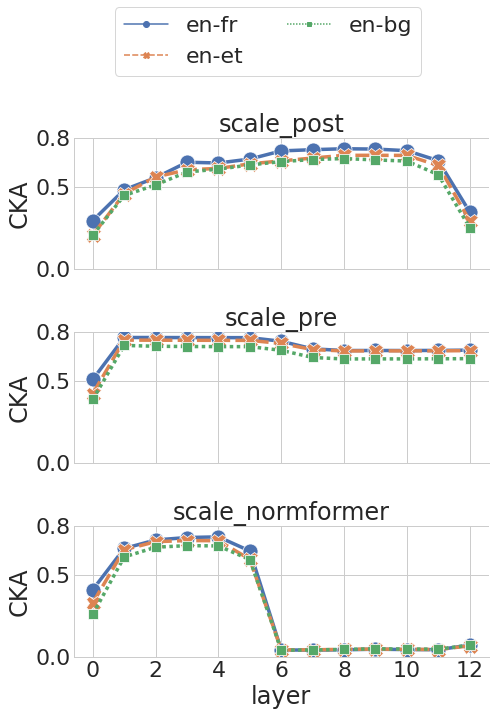

In [6]:

dfs = load_dfs(["norm_1M"], ["cka"])
df = dfs["norm_1M"]
y_name = "CKA"

df.rename(columns = {'score':y_name}, inplace=True)

#a4_dims = (8, 4)
#fig, ax = plt.subplots(figsize=a4_dims)

g = sns.relplot(
        # ax=ax,
        row="model",
        row_order=["scale_post", "scale_pre", "scale_normformer"], 
        data=df, 
        x="layer", 
        y=y_name, 
        hue="pair", 
        style="pair", 
        markers=True, 
        #row="model",
        #col="analysis",
        kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=15,
        aspect=2.5,
        height=3
        #facet_kws={"legend_out": True}
        )

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.42, 1), ncol=2, title=None, frameon=True,
)
# leg = plt.legend(frameon=True)
plt.xticks(range(0,13,2))
plt.ylabel(y_name)
g.set(ylim=(0, 0.8))
plt.yticks([0,0.5,0.8])

#move overall title up
# g.fig.subplots_adjust(top=.8)

#add overall title
# g.fig.suptitle('Stats by Team')
(g.set_titles("{row_name}")
  .tight_layout(w_pad=0))

g.figure.savefig(f"../assets/motivating-examples/all_{y_name}.pdf", dpi=300, bbox_inches='tight')



Seems CKA did not XLM-R Normformer (scale_normformer) right

#### Lets verify it is not a coincidence and check CKA scores for another XLM-R Normformer pretrained from another random restart.

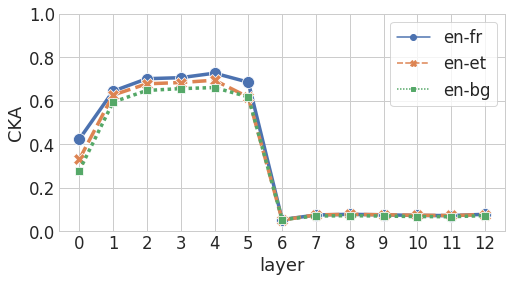

In [94]:

dfs = load_dfs(["norm_1M_v2"], ["cka"])
df = dfs["norm_1M_v2"][dfs["norm_1M_v2"].model == "scale_normformer-v2"]
y_name = "CKA"

a4_dims = (8, 4)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.lineplot(
        ax=ax,
        data=df, 
        x="layer", 
        y="score", 
        hue="pair", 
        style="pair", 
        markers=True, 
        #row="model",
        #col="analysis",
        #kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=12,
        #aspect=1.5
        #facet_kws={"legend_out": True}
        )

leg = plt.legend(frameon=True)
plt.xticks(range(13))
plt.ylabel(y_name)
plt.ylim(0,1)

g.figure.savefig(f"../assets/motivating-examples/normformerv2_cka.pdf", dpi=300, bbox_inches='tight')



### Let us see what our Sentence Matching Task has to say about representations at deep layers

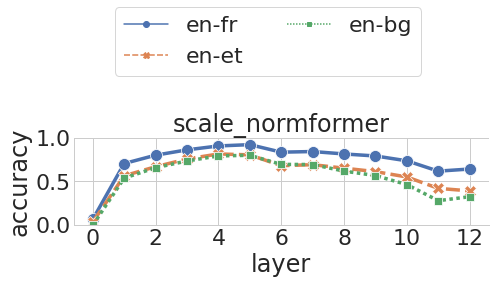

In [8]:

dfs = load_dfs(["norm_1M"], ["acc"])
df = dfs["norm_1M"]
y_name = "accuracy"

df.rename(columns = {'score':y_name}, inplace=True)

#a4_dims = (8, 4)
#fig, ax = plt.subplots(figsize=a4_dims)

g = sns.relplot(
        # ax=ax,
        row="model",
        #row_order=["scale_post", "scale_pre", "scale_normformer"], 
        data=df[df.model=="scale_normformer"], 
        x="layer", 
        y=y_name, 
        hue="pair", 
        style="pair", 
        markers=True, 
        #row="model",
        #col="analysis",
        kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=12,
        aspect=2.5,
        height=3
        #facet_kws={"legend_out": True}
        )

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.42, 1), ncol=2, title=None, frameon=True,
)
# leg = plt.legend(frameon=True)
plt.xticks(range(0,13,2))
plt.yticks([0, 0.5, 1])
plt.ylabel(y_name)
plt.ylim(0,1)

#move overall title up
# g.fig.subplots_adjust(top=.8)

#add overall title
# g.fig.suptitle('Stats by Team')

#g.figure.savefig(f"../assets/motivating-examples/normformer_cka.pdf", dpi=300, bbox_inches='tight')

(g.set_titles("{row_name}")
  .tight_layout(w_pad=0))

g.figure.savefig(f"../assets/motivating-examples/all_{y_name.lower()}.pdf", dpi=300, bbox_inches='tight')



Our Matching Task Confirms there is a similarity between depper layers CKA fails to reveal.

# Our Method: Average Neuron-Wise Alignment (ANC)

### Sanitty check: mBERT + XLM-R Base

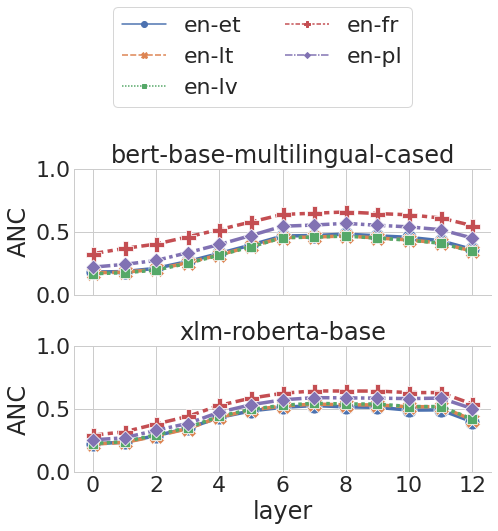

In [9]:

dfs = load_dfs(["xlmrb"], ["corr"])
df = dfs["xlmrb"]

dfs = load_dfs(["mbert"], ["corr"])
df2 = dfs["mbert"]

df = pd.concat([df,df2])

y_name = "ANC"

df.rename(columns = {'score':y_name}, inplace=True)

#a4_dims = (8, 4)
#fig, ax = plt.subplots(figsize=a4_dims)

g = sns.relplot(
        # ax=ax,
        row="model",
        row_order=["bert-base-multilingual-cased", "xlm-roberta-base"], 
        data=df, 
        x="layer", 
        y=y_name, 
        hue="pair", 
        style="pair", 
        markers=True, 
        #row="model",
        #col="analysis",
        kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=15,
        aspect=2.5,
        height=3
        #facet_kws={"legend_out": True}
        )

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.45, 1), ncol=2, title=None, frameon=True,
)
# leg = plt.legend(frameon=True)
plt.xticks(range(0,13,2))
plt.ylabel(y_name)
plt.ylim(0,1)

(g.set_titles("{row_name}"))

#move overall title up
# g.fig.subplots_adjust(top=.8)

#add overall title
# g.fig.suptitle('Stats by Team')

g.figure.savefig(f"../assets/motivating-examples/sanity_{y_name}.pdf", dpi=300, bbox_inches='tight')



### Sanity Check: XLM-R Normformer

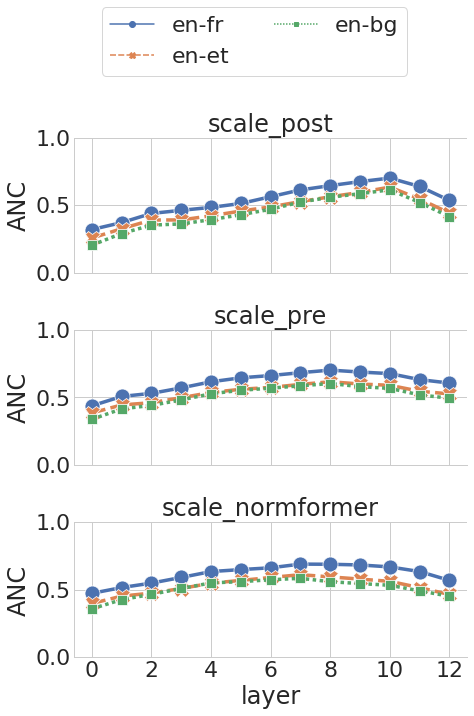

In [10]:

dfs = load_dfs(["norm_1M"], ["corr"])
df = dfs["norm_1M"]
y_name = "ANC"

df.rename(columns = {'score':y_name}, inplace=True)

#a4_dims = (8, 4)
#fig, ax = plt.subplots(figsize=a4_dims)

g = sns.relplot(
        # ax=ax,
        row="model",
        row_order=["scale_post", "scale_pre", "scale_normformer"], 
        data=df, 
        x="layer", 
        y=y_name, 
        hue="pair", 
        style="pair", 
        markers=True, 
        #row="model",
        #col="analysis",
        kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=15,
        aspect=2.5,
        height=3
        #facet_kws={"legend_out": True}
        )

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.4, 1), ncol=2, title=None, frameon=True,
)

(g.set_titles("{row_name}")
  .tight_layout(w_pad=0))

# leg = plt.legend(frameon=True)
plt.xticks(range(0,13,2))
plt.ylabel(y_name)
plt.ylim(0,1)

#move overall title up
# g.fig.subplots_adjust(top=.8)

#add overall title
# g.fig.suptitle('Stats by Team')

g.figure.savefig(f"../assets/motivating-examples/all_{y_name}.pdf", dpi=300, bbox_inches='tight')



# Scaling Laws

In [257]:
sns.set(font_scale=2.5) 
plt.style.use('seaborn-whitegrid')

In [258]:
aspect=1.5
height=4

### XLM-R

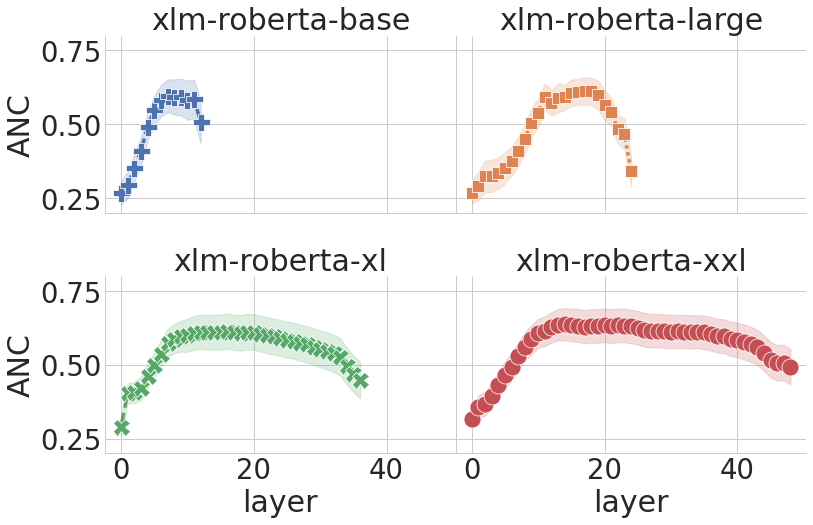

In [259]:

mdl="xlmr"
dfs = load_dfs([mdl], ["corr"])
df = dfs[mdl]
y_name = "ANC"
order = ["xlm-roberta-base", "xlm-roberta-large", "xlm-roberta-xl", "xlm-roberta-xxl"]

df.rename(columns = {'score':y_name}, inplace=True)

#a4_dims = (8, 4)
#fig, ax = plt.subplots(figsize=a4_dims)

g = sns.relplot(
        col="model",
        col_wrap=2,
        data=df, 
        x="layer", 
        y=y_name, 
        hue="model",
        hue_order=order, 
        col_order=order, 
        style="model", 
        markers=True, 
        #row="model",
        #col="analysis",
        kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=17,
        aspect=aspect,
        height=height,
        legend=False,
        #facet_kws={"legend_out": True},
        #facet_kws={"legend_out": True}
        )

plt.ylabel(y_name)
plt.ylim(0.2,0.8)

# sns.move_legend(
#     g, "lower center",
#     bbox_to_anchor=(.45, 1), ncol=2, title=None, frameon=True,
# )

(g.set_titles("{col_name}")
  .tight_layout(w_pad=0))


g.figure.savefig(f"../assets/motivating-examples/laws_{mdl}_{y_name.lower()}.pdf", dpi=300, bbox_inches='tight')




### XGLM

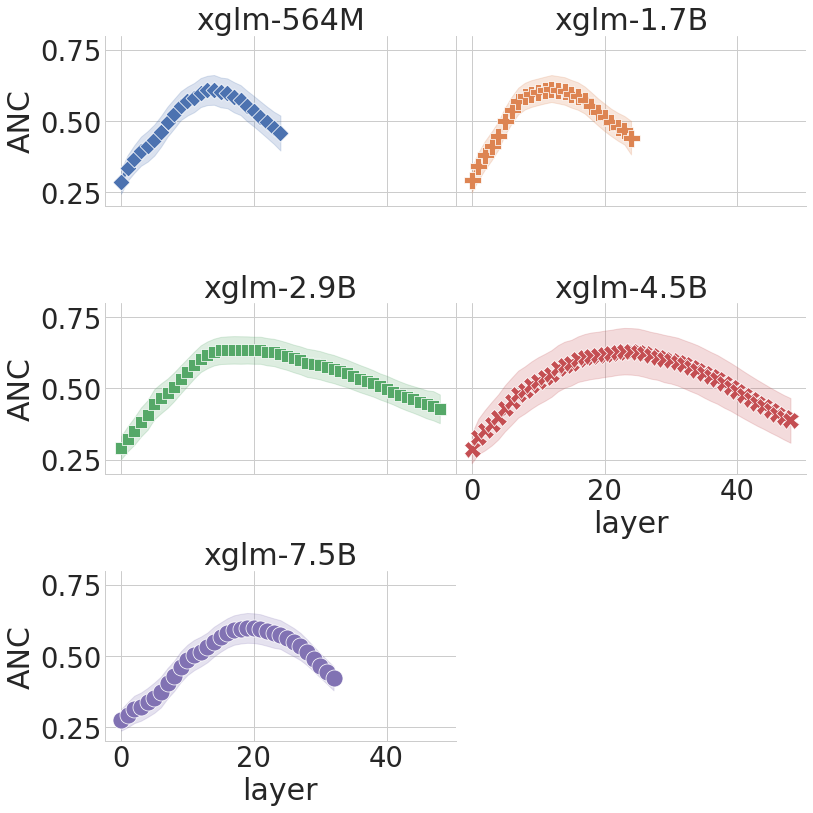

In [260]:

mdl="xglm"
dfs = load_dfs([mdl], ["corr"])
df = dfs[mdl]
y_name = "ANC"

order = list(reversed(["xglm-7.5B", "xglm-4.5B", "xglm-2.9B", "xglm-1.7B", "xglm-564M"]))

df.rename(columns = {'score':y_name}, inplace=True)

#a4_dims = (8, 4)
#fig, ax = plt.subplots(figsize=a4_dims)
g = sns.relplot(
        col="model",
        col_wrap=2,
        data=df, 
        x="layer", 
        y=y_name, 
        hue="model",
        hue_order=order, 
        col_order=order, 
        style="model", 
        markers=True, 
        #row="model",
        #col="analysis",
        kind="line", 
        ci="sd",
        linewidth=3.5,
        markersize=17,
        aspect=aspect,
        height=height,
        legend=False,
        #facet_kws={"legend_out": True},
        #facet_kws={"legend_out": True}
        )

plt.ylabel(y_name)
plt.ylim(0.2,0.8)

# sns.move_legend(
#     g, "lower center",
#     bbox_to_anchor=(.45, 1), ncol=2, title=None, frameon=True,
# )

(g.set_titles("{col_name}")
  .tight_layout(w_pad=0))


g.figure.savefig(f"../assets/motivating-examples/laws_{mdl}_{y_name.lower()}.pdf", dpi=300, bbox_inches='tight')


